# Lab Report 1: Alpha Oscillations in Scalp EEG 
## Step 1: Preprocess Data 
Note that this assumes prior conversion of the EEG data to MNE fiff format. 

In [1]:
import numpy as np
from mne import Epochs, make_fixed_length_events
from mne.io import Raw
from mne.time_frequency import psd_multitaper

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
eeg_files = [2, 3, 4, 5, 8, 9, 10, 11,   # Day 1
             12, 13, 14, 15, 16, 17] # Day 2

## Filtering parameters.
l_freq = 0.5
h_freq = 20

## Epoching parameters.
tmin = 0.0
tmax = 2.0
baseline = None
reject = dict(eeg = 100e-6)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for f in eeg_files:
    
    ## Load data.
    raw = Raw('raw/eeg%0.2d_raw.fif' %f, preload=True, verbose=False)
    
    ## Filter data.
    raw = raw.filter(l_freq, h_freq, method='fir', phase='zero', verbose=False)
    
    ## Epoch data.
    events = make_fixed_length_events(raw, id=1)
    event_id = dict(epoch=1)
    epochs = Epochs(raw, events, event_id, tmin=tmin, tmax=tmax, baseline=baseline, 
                    reject=reject, verbose=False)
    
    ## Drop bad epochs (amplitude rejection).
    epochs.drop_bad(verbose=False)
    print(epochs)
    
    ## Estimate power spectrum density.
    psds, freqs = psd_multitaper(epochs, fmin=l_freq, fmax=h_freq, tmin=0)
    psds = 10 * np.log10(psds) # Decibel conversion.
    
    ## Save data.
    np.savez_compressed('ave/eeg%0.2d_report' %f, psds=psds.squeeze(), freqs=freqs)
    
print('Done.')

<Epochs  |  n_events : 65 (all good), tmin : 0.0 (s), tmax : 2.0 (s), baseline : None, ~8 kB, data not loaded>
<Epochs  |  n_events : 56 (all good), tmin : 0.0 (s), tmax : 2.0 (s), baseline : None, ~8 kB, data not loaded>
<Epochs  |  n_events : 68 (all good), tmin : 0.0 (s), tmax : 2.0 (s), baseline : None, ~8 kB, data not loaded>
<Epochs  |  n_events : 56 (all good), tmin : 0.0 (s), tmax : 2.0 (s), baseline : None, ~8 kB, data not loaded>
<Epochs  |  n_events : 63 (all good), tmin : 0.0 (s), tmax : 2.0 (s), baseline : None, ~8 kB, data not loaded>
<Epochs  |  n_events : 39 (all good), tmin : 0.0 (s), tmax : 2.0 (s), baseline : None, ~8 kB, data not loaded>
<Epochs  |  n_events : 131 (all good), tmin : 0.0 (s), tmax : 2.0 (s), baseline : None, ~8 kB, data not loaded>
<Epochs  |  n_events : 169 (all good), tmin : 0.0 (s), tmax : 2.0 (s), baseline : None, ~8 kB, data not loaded>
<Epochs  |  n_events : 43 (all good), tmin : 0.0 (s), tmax : 2.0 (s), baseline : None, ~8 kB, data not loaded>

## Step 2: Analyze Data

One-way ANOVA: F = 1019.632, p = 0.000
EO < UM t-test: t = -21.629, p = 0.000
UM < DM t-test: t = -19.157, p = 0.000
DM < EC t-test: t = -0.704, p = 0.482


/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


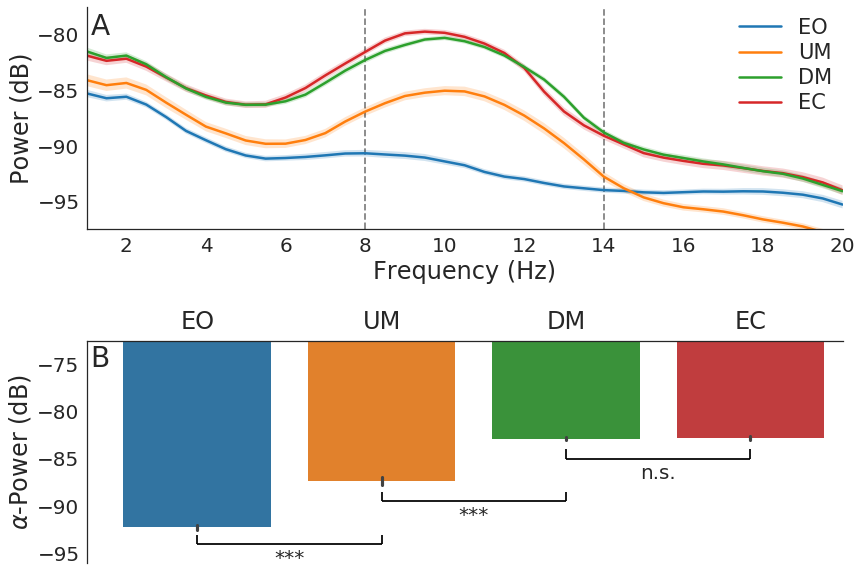

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, concat
from scipy.stats import f_oneway, ttest_ind
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
eeg_conds = {'EO':[2, 4, 8, 12, 14],
             'EC':[3, 5, 9, 13, 15],
             'DM':[10, 16],
             'UM':[11, 17]}

## Spectral parameters.
alpha_lim = (8, 14)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

data = []
for desc, files in eeg_conds.items():
    
    for f in files:
        
        ## Load and extract data.
        npz = np.load('ave/eeg%0.2d_report.npz' %f)
        psds = npz['psds']
        freqs = npz['freqs'].round(1)
        
        ## Convert PSD to DataFrame. Append.
        df = DataFrame(psds, columns=freqs)
        df['Condition'] = desc
        data.append(df)
        
## Concatenate DataFrames.  
data = concat(data)
data['Trial'] = np.arange(data.shape[0])
data = data.melt(id_vars=('Condition','Trial'), var_name='Freq', value_name='dB')

## Generate alpha-only DataFrame.
alpha = data[np.logical_and(data.Freq>=8, data.Freq<=14)]
alpha = alpha.groupby(['Condition','Trial']).mean().reset_index()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## One-way ANOVA.
F, p = f_oneway(*[alpha.loc[alpha.Condition==c,'dB'].as_matrix() for c in alpha.Condition.unique()])
print('One-way ANOVA: F = %0.3f, p = %0.3f' %(F,p))

## Post-hoc t-tests.
for c1, c2 in [('EO','UM'),('UM','DM'),('DM','EC')]:
    t, p = ttest_ind(alpha.loc[alpha.Condition==c1,'dB'], alpha.loc[alpha.Condition==c2,'dB'])
    print('%s < %s t-test: t = %0.3f, p = %0.3f' %(c1,c2,t,p))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

def sig_bars(ax,x1,x2,y1,y2,s):
    ax.vlines([x1,x2],y1,y2)
    ax.hlines([y2],x1,x2)
    ax.text((x1+x2)/2, y2-0.5, s, fontsize=20, va='top', ha='center')

fig, axes = plt.subplots(2,1,figsize=(12,8))

## PSD.
sns.tsplot(data, time='Freq', unit='Trial', condition='Condition', value='dB',  ci=95, 
           color=['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e'], linewidth=2.5, ax=axes[0])
axes[0].vlines([8,14], -97.5, -77.5, linestyle='--', color='k', alpha=0.5)
axes[0].set(xticks=np.arange(2,21,2), ylim=(-97.5,-77.5))
axes[0].set_xlabel('Frequency (Hz)', fontsize=24)
axes[0].set_ylabel('Power (dB)', fontsize=24)
axes[0].text(1.1, -78, 'A', fontsize=28, ha='left', va='top')
sns.despine(ax=axes[0])

## Fix legend.
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend([handles[0], handles[3], handles[2], handles[1]], ['EO','UM','DM','EC'],
               loc=0, borderpad=0, labelspacing=0.25, fontsize=21)

## Barplot.
sns.barplot('Condition', 'dB', data=alpha, order=['EO','UM','DM','EC'], ci=95, ax=axes[1])
axes[1].set(xlim=(-0.6,3.5), xlabel='', ylim=(-96,-72.5))
axes[1].set_xticklabels(['EO','UM','DM','EC'], fontsize=24)
axes[1].set_ylabel(r'$\alpha$-Power (dB)', fontsize=24)
axes[1].text(-0.58, -73, 'B', fontsize=28, ha='left', va='top')
sns.despine(ax=axes[1], top=False, bottom=True)

## Add significance bars.
sig_bars(axes[1], 0, 1, -93, -94, '***')
sig_bars(axes[1], 1, 2, -88.5, -89.5, '***')
sig_bars(axes[1], 2, 3, -84, -85, 'n.s.')

plt.subplots_adjust(left=0.1, right=0.975, top=0.99, bottom=0.025, hspace=0.5)
plt.savefig('eeg_report.png', dpi=300)